# Twitter data and Natural Language Processing in Python

*tweetskit.py* contains methods specific to the analysis of twitter data collected using methods implemented in *tweets.py*

This notebook aims to showcase some of the possible usage of the implementation on Brexit related twitter data

In [1]:
import sys
tweets_path = r'C:\Users\David\Documents\00 - DAI SCIENCE PRO\01 - DAISCIENCE (GITHUB)\02 - EMAILS'
sys.path.append(tweets_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load required modules
import tweets     # user-defined tweets.py, manage tweet database
import tweetskit  # user-defined tweetskit.py, analyze tweet database

C:\Users\David\AppData\Roaming\Python\Python36\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Note files *tweets.py* and *tweetskit.py* should be located in working directory or parent directory of the files should be added to *sys.path*

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
tweets.load_db()
data = tweets.to_pandas()
print(data.shape)
data.head()

(1433087, 5)


id                date                        date_str  \
0  1040752052312453120 2018-09-15 00:00:00  Sat Sep 15 00:00:00 +0000 2018   
1  1040752053230792705 2018-09-15 00:00:00  Sat Sep 15 00:00:00 +0000 2018   
2  1040752055537860608 2018-09-15 00:00:00  Sat Sep 15 00:00:00 +0000 2018   
3  1040752057379115009 2018-09-15 00:00:01  Sat Sep 15 00:00:01 +0000 2018   
4  1040752060298395649 2018-09-15 00:00:02  Sat Sep 15 00:00:02 +0000 2018   

                                               tweet lang  
0  There are 4691 hours until #Brexit - For a rea...   en  
1  Стоимость ВВП Великобритании вырастет на $21 м...   ru  
2  wow, thanks for spreading this good news, i ha...   en  
3  Gathering with @Erica_Mckoy was on exploring B...   en  
4  The fate of the EU after Brexit will depend on...   en

Data contains around 1.5 million tweets, date and language of the tweet. Retweets have **not** been collected for the purpose of this analysis so each tweet is unique although it can be a response to a previous tweet, related to brexit or not

In [6]:
# setup some default matplotlib and seaborn parameters for better visualisation
tweetskit.set_plot_param()

## Trend analysis

The number of tweets on a given period can be charted using plot_tweet for various time series frequencies

On an hourly basis, we clearly distinguish a daily trend (beginning and end of the day) while it is unclear if there is a weekly trend with a break slow down or acceleration of tweet frequency over the weekend for example

In [7]:
tweetskit.plot_tweets(data, rule='h', bar=True);

In [8]:
tweetskit.plot_tweets(data, rule='d', bar=True);

In [9]:
tweetskit.plot_tweets(data, rule='h', rolling=24, bar=True);

## Anomaly detection

Some periods clearly stand out, there is at least one period on the 21/09/2018 with a high number of tweets (>10,000) whereas the hourly volume of tweet rarely exceeds 4,000

Using an anomaly detection algorythm based on convolution, we can easily highlight periods where the number of tweets vary too much from expected average. The method is parametric and require to define a base period (example hour), expected period (24) and a threshold (2 times the standard deviation)

Note this method implements stationary standard deviation and rolling standard deviation - given the data, we are using rolling standard deviation and not stationary standard deviation 

*The first 3 anomalies detected can be linked to the mayor of London calling for a second Brexit referundum while the last 3 can be linked to prime minister speaches (main peak is linked to no deal)*

In [10]:
tweetskit.plot_anomaly(data, rule='h', period=24, threshold=2, bar=True, stationary=False)

[(Timestamp('2018-09-15 08:00:00', freq='H'), 1801),
 (Timestamp('2018-09-15 09:00:00', freq='H'), 1778),
 (Timestamp('2018-09-16 09:00:00', freq='H'), 3048),
 (Timestamp('2018-09-21 13:00:00', freq='H'), 11560),
 (Timestamp('2018-09-30 09:00:00', freq='H'), 4101),
 (Timestamp('2018-10-03 11:00:00', freq='H'), 4604)]

## Trend change detection

It's not easy drawing any conclusion on behaviour related to Brexit using solely the number of tweets charted over time. Let's test the hypothesis the expected number of tweets is changing over time and build a bayesian model 

Assuming the number of tweets follows an exponential distribution of parameter $\lambda$, let's model $\lambda_1$ for the parameter of the number of tweet before moment $\tau$ when distribution changes from $\lambda_1$ to $\lambda_2$

In [12]:
counts = tweetskit.get_counts(data)
trace = tweetskit.get_trace(counts, draws=10000, tune=5000, chains=4, cores=4, random_state=2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 60000/60000 [00:38<00:00, 1539.34draws/s]
The number of effective samples is smaller than 25% for some parameters.


                 mean        sd  mc_error      hpd_2.5     hpd_97.5  \
tau        382.000000  0.000000  0.000000   382.000000   382.000000   
lambda_1  2059.848497  2.319551  0.028514  2055.265873  2064.392487   
lambda_2  1785.185813  2.196764  0.025623  1780.866824  1789.508369   

                n_eff      Rhat  
tau               NaN       NaN  
lambda_1  7138.889326  1.000483  
lambda_2  7264.999318  1.000156  


Simulation results suggest two distinct distributions one with around 2059 tweets expected and the other one with 1785 tweets expected on an hourly basis

From plotting the trace, i.e. visualisig the results of the simulation, it appears the two posterior distributions are clearly distinct and the value of $\tau$ is around the 30/09/2018 (282nd time frequency)

We can also plot expected number of tweets over time versus actal number of tweet

In [13]:
tweetskit.plot_trace(trace, counts);

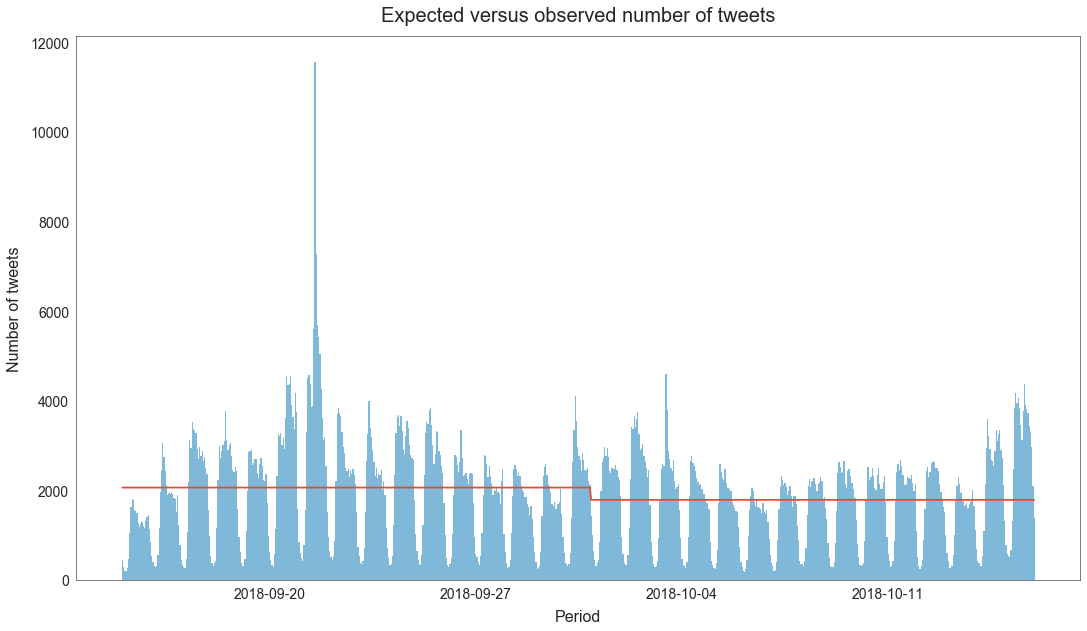

In [14]:
tweetskit.plot_expected(trace, counts, bar=True);

## Trend forecasting (ARIMA)

Given the shape of our data, a simple arima model should be sufficent to forecast the future number of tweets

Decomposition confirms the trend observed on previous results and residuals do not show obvious signs of autocorrelation

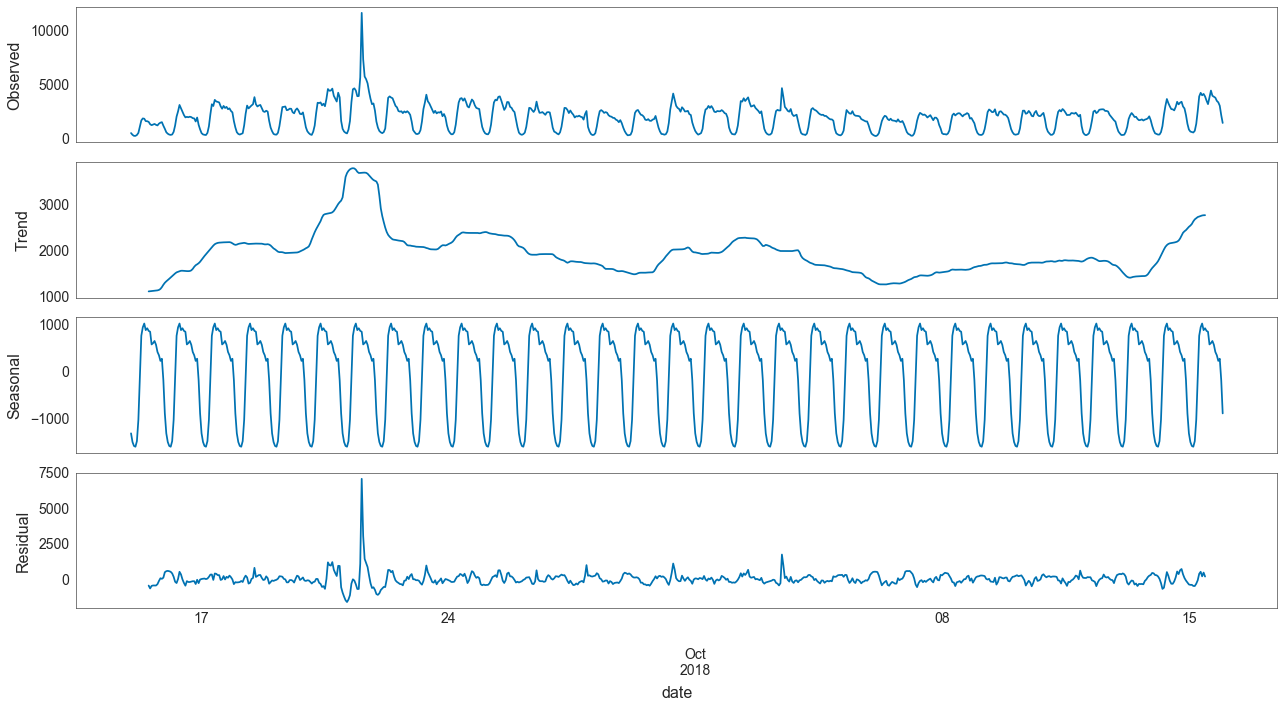

In [15]:
counts = tweetskit.decompose(data, rule='h');

We will implement a simple grid search to estimate the best parameter *p,d* and *q* for the arima model that best describe our data

In [16]:
p = range(0, 2)
d = q = range(0, 2)
m = 24
pdq, spdq = tweetskit.create_combinations(p, d, q, m, p, d, q)

In [17]:
grid = tweetskit.grid_search(counts, pdq, spdq)

Grid searching 64 combinations


Note I am scoring each model based on the summary statistics (in sample akaike information and bayes information criterion, out of sample mean squared, mean absolute and mean absolute scaled errors) with each having an equal weight in my final scoring but this weights can be adjusted to best fit the purpose of the forecast

In [18]:
scored = tweetskit.score_grid(grid)

(4.6, (1, 0, 1), (1, 1, 1, 24), (7065.3371, 7086.1007, 392.42, 518.425, 0.2052))
(5.2, (1, 0, 0), (1, 1, 1, 24), (7078.2336, 7094.853, 391.711, 517.6384, 0.2059))
(6.0, (1, 0, 1), (0, 1, 1, 24), (7067.5636, 7084.1745, 396.5157, 524.5002, 0.2074))
(6.8, (1, 0, 0), (0, 1, 1, 24), (7080.5965, 7093.0611, 395.9243, 523.5338, 0.2091))
(9.8, (0, 0, 1), (0, 1, 1, 24), (7307.9986, 7320.4568, 329.3747, 537.9829, 0.1919))
(9.8, (0, 0, 1), (1, 1, 1, 24), (7272.0222, 7288.6331, 369.0424, 496.3813, 0.1931))
(13.0, (1, 0, 1), (1, 0, 1, 24), (7414.7035, 7435.7162, 359.5319, 589.6106, 0.2071))
(13.4, (1, 0, 0), (1, 0, 1, 24), (7427.5377, 7444.356, 358.674, 588.8274, 0.2075))
(14.2, (1, 0, 1), (1, 1, 0, 24), (7203.0201, 7219.6396, 484.8722, 707.1169, 0.312))
(14.4, (1, 0, 0), (1, 1, 0, 24), (7202.8906, 7215.3552, 493.4883, 713.3676, 0.3254))


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8216      0.022     36.524      0.000       0.778       0.866
ma.L1          0.0806      0.032      2.555      0.011       0.019       0.142
ar.S.L24       0.1086      0.016      6.772      0.000       0.077       0.140
ma.S.L24      -1.0214      0.098    -10.456      0.000      -1.213      -0.830
sigma2      1.269e+05   1.33e+04      9.528      0.000    1.01e+05    1.53e+05


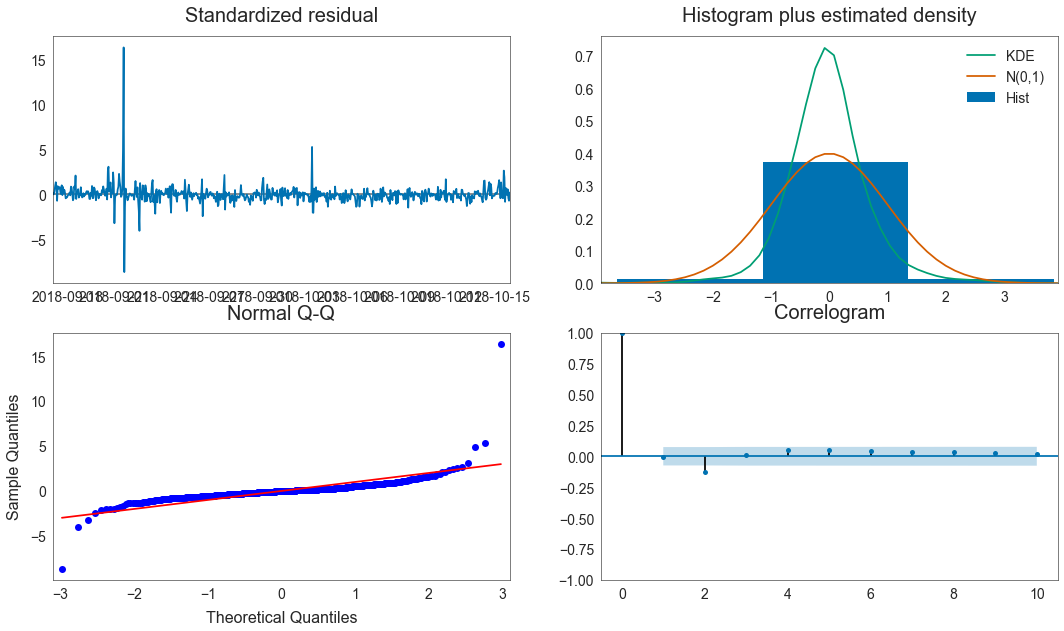

In [19]:
model = tweetskit.get_arima(counts, scored[0][1], scored[0][2], summary=True)

The model is not perfect but residuals seems to be normaly distributed and there is no sign of autocorrelation. Recommendation would be to adjust the extrema before moving forward with such a model however a one-step-forward prediction of teh number of tweet is really 

## Word cloud

Moving away from trend analysis to text analytics, let's first look at the most common and important words or combination of words in our tweets

Not all the tweets are made in english and we will filter non-english out. Note twitter is inferring the tweet language from the actual tweet (undefined represent tweets without enough meaningful words t classify the tweet) 

We will also perform basic preprocessing on the tweet data before generation a word cloud

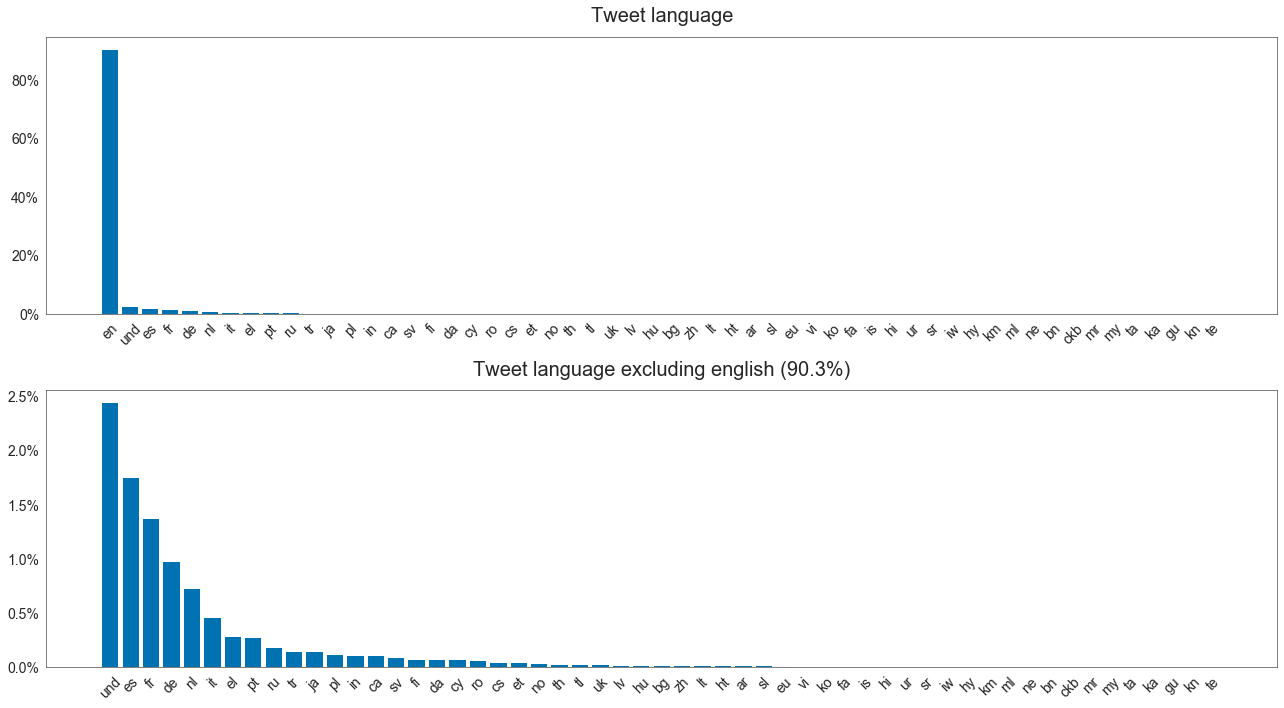

In [20]:
tweetskit.plot_language(data);

In [21]:
data_en = data[data.lang=='en']
print(data_en.shape)

(1293970, 5)


In [22]:
cleaned_data = tweetskit.clean_tweets(data_en, copy=True)

executing <function remove_amp at 0x000001F50ACDF730> on tweet
executing <function remove_users at 0x000001F50ACDF840> on tweet
executing <function remove_links at 0x000001F50ACDF7B8> on tweet
executing <function lower_case at 0x000001F50ACDF8C8> on tweet
executing <function remove_punctuation at 0x000001F50ACDF950> on tweet
executing <function remove_stopword at 0x000001F50ACDF9D8> on tweet


In [23]:
cleaned_data.head()

id                date                        date_str  \
0  1040752052312453120 2018-09-15 00:00:00  Sat Sep 15 00:00:00 +0000 2018   
2  1040752055537860608 2018-09-15 00:00:00  Sat Sep 15 00:00:00 +0000 2018   
3  1040752057379115009 2018-09-15 00:00:01  Sat Sep 15 00:00:01 +0000 2018   
4  1040752060298395649 2018-09-15 00:00:02  Sat Sep 15 00:00:02 +0000 2018   
5  1040752062986969089 2018-09-15 00:00:02  Sat Sep 15 00:00:02 +0000 2018   

                                               tweet lang  
0   4691 hours brexit realtime countdown clock visit   en  
2  wow thanks spreading good news hadnt heard app...   en  
3  gathering exploring brexit music interviewed j...   en  
4  fate eu brexit depend britain able function so...   en  
5                      brexit 4702 hours away brexit   en

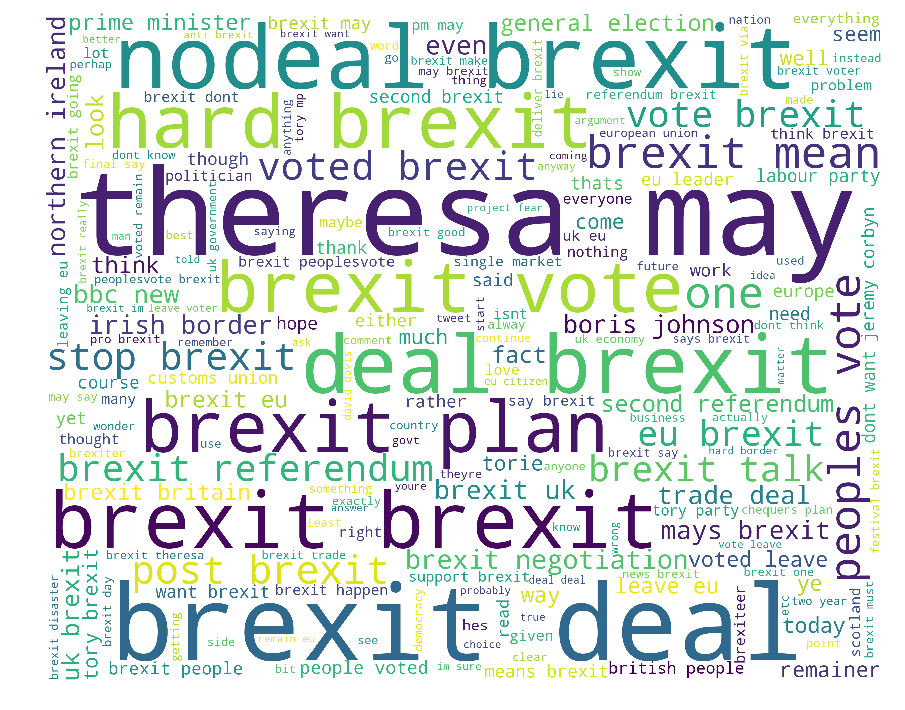

In [24]:
tweetskit.plot_wordcloud(' '.join(cleaned_data['tweet']), mask=None);

We clearly see some bigram appearing (theresa may, brexit vote, hard brexit, peoples vote, northern ireland etc) and I think a wordcloud is a good first step in visualising most important data

We can play with data visualisation by adding a mask for the wordcloud to be plot with although the scaling needs more work done for the picture to be clean  

In [25]:
tweetskit.plot_wordcloud(' '.join(cleaned_data['tweet']), mask='twitter_mask.png');

## Data cleaning and ngrams

Before trying to model the topic and subjects in our tweet, let's preprocess the data. I will work on a 20% sample to speed up the process a bit

In [26]:
sample_ratio = 0.1
state = 1
sample = data[data.lang=='en'].sample(frac=sample_ratio, random_state=state).reset_index()

In [27]:
texts = tweetskit.get_texts(sample) # faster version of basic clean, lemmatization and tokenisation

In [28]:
texts = tweetskit.add_ngram(texts, ngram=3)

Looking at the data, we see some bigram and trigram generated

In [29]:
texts[:4]

[['cant',
  'get',
  'arrogance',
  'contempt',
  'politician',
  'shown',
  'democratic vote',
  '174 million people',
  'audacity',
  'call',
  'democrat',
  'trying',
  'best',
  'sabotage',
  'brexit',
  'dishonourable',
  'sanctimonious',
  'shower'],
 ['sum',
  'brexit',
  'really',
  'one',
  'photo',
  'minority',
  'people',
  'want',
  'lunacy',
  'majority',
  'want',
  'remain'],
 ['every time see',
  'attack',
  'soros',
  'almost certain',
  'writer',
  'putin',
  'tool',
  'putin',
  'fear',
  'loathes',
  'soros',
  'work',
  'building',
  'democracy',
  'easter',
  'europe'],
 ['say', 'irrelevant', 'waste time']]

## Word importance using Term Frequency Inverse Document Frequency

Before classifying our tweet, we can also look at word importance. The idea is some words (or combination of words) will not help classifying our text as present too often 

The term frequency inversed document frequency is a very common measure to look at word importance and is implemented as part of most search engine. The function returns a dictionary of word and equivalent importance score, print some distribution score percentiles along the way and the most important score words

Unsuprisingly, most important words in brexit related tweets are *brexit*, *eu* and *uk*. We can look at some specific scores to help defining the list of words to filter out of the rest of our analysis 

In [30]:
tfidf_scores = tweetskit.get_tfidf_scores(texts, ngram_range=(1,3), verbose=True)

[(0.001, 4.258585565698335), (0.005, 5.250221015766088), (0.01, 5.691898215044125), (0.05, 7.087824826787669), (0.1, 7.773435931214838), (0.25, 8.745296514243803), (0.5, 9.438443694803748), (0.75, 9.826209225812512), (0.9, 9.998059482739171), (0.95, 10.062598003876742), (0.99, 10.062598003876742), (0.999, 10.062598003876742)]

brexit 1.3712050371134148
eu 3.028562558984275
uk 3.1510499266559084
deal 3.392000687594393
may 3.4597387780810736
people 3.523783058320397
vote 3.59936056026647
ha 3.62901503101256
would 3.6561581586596033
wa 3.7623016255942443
say 3.7808298236120272
amp 3.870917410098255
get 3.939959006217954
like 3.9588469810402
labour 3.9646735456676323
want 4.019490223616922
one 4.057066199557324
theresa 4.132299892006247
think 4.1794613336543875
referendum 4.246479399826289


In [31]:
print(tfidf_scores['theresa may'], tfidf_scores['boris johnson'])

4.400563878600927 6.0736139573124674


In [32]:
brexit_exclude = [key for key in tfidf_scores if tfidf_scores[key]<4.4]

## Topic modelling using Latent Dirichlet Allocation

One key thing in text analytics is the identification of topics within texts. Let's try to extract four topics from our Brexit related tweets

In [33]:
texts = [[token for token in text if token not in brexit_exclude] for text in texts]

In [34]:
corpus, dictionary = tweetskit.get_corpus(texts)

We can visualise the topic extracted using the correlation matrix of the words explaining each topic the most. It can also be used to assess if topics are discriminant enough

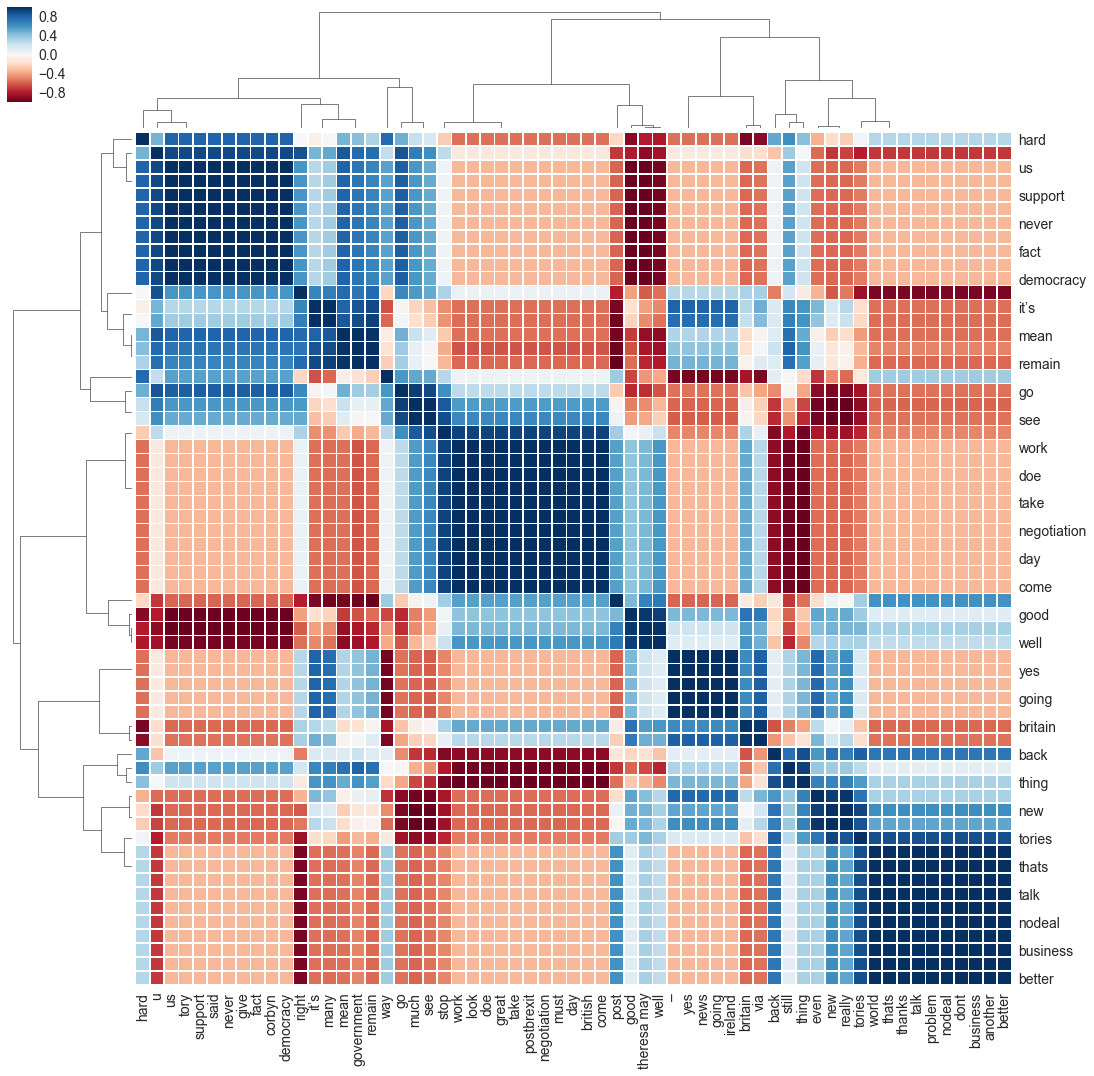

In [35]:
lda = tweetskit.get_lda(corpus, dictionary, 4, random_state=1)

In [51]:
lda.show_topics(4, 10)

[(1,
  '0.005*"theresa may" + 0.004*"stop" + 0.003*"good" + 0.003*"via" + 0.003*"see" + 0.003*"must" + 0.003*"work" + 0.003*"negotiation" + 0.003*"britain" + 0.002*"fear"'),
 (5,
  '0.004*"right" + 0.003*"stop" + 0.003*"still" + 0.003*"going" + 0.003*"it’s" + 0.003*"2" + 0.003*"come" + 0.003*"really" + 0.003*"government" + 0.002*"must"'),
 (4,
  '0.006*"well" + 0.005*"see" + 0.004*"britain" + 0.004*"tories" + 0.004*"tory" + 0.003*"way" + 0.003*"good" + 0.003*"going" + 0.003*"still" + 0.003*"stop"'),
 (3,
  '0.006*"via" + 0.005*"it’s" + 0.005*"going" + 0.004*"even" + 0.004*"many" + 0.003*"mean" + 0.003*"government" + 0.003*"–" + 0.003*"theresa may" + 0.003*"news"')]

Identifying topics is more an art than a science and this exercise is particularly difficult as all text here are really related to only one subject by definition (Brexit). However some *subtopics* are emerging

Also note at this step we should go back and clean our data a little more

## Number of topics using hierarchical Dirichlet process

There is currently no out of the box solution to determine the number of topic present in a corpus. The idea below is to create as many topics as possible and look at the contribution of each topic in the overall corpus in a hierarchical Dirichlet process via the *alpha* parameter. The non parametric trick is to use a very high number of topic (500 topics here although we are plotting only alpha contribution up to topic 100)



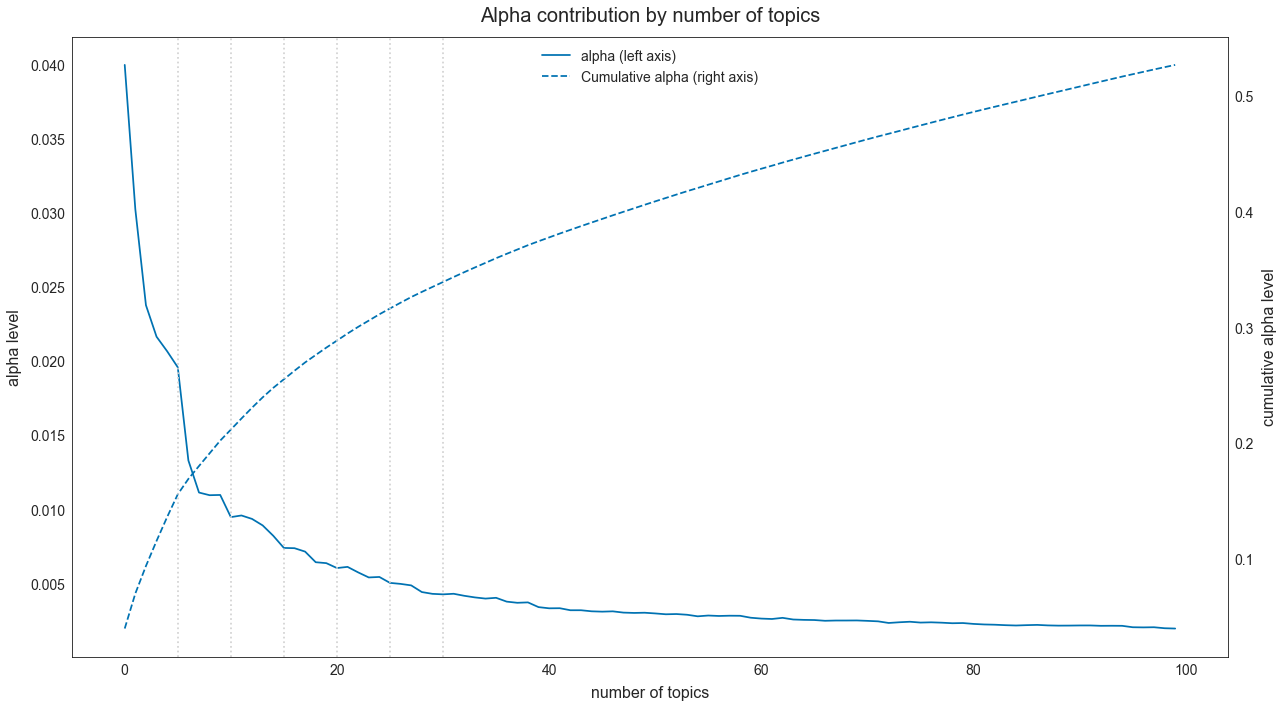

In [37]:
hdp = tweetskit.get_hdp(corpus, dictionary, random_state=1)

6 topics seems to be the moment the curve flatten. An alternative choice would have been 10 if we wanted to have a higher number of topics

Let's run the same process and look at some basic distribution and counts, contribution of top topic per tweet and look at the most representativ tweet for each topic

In [46]:
num_topic = 6

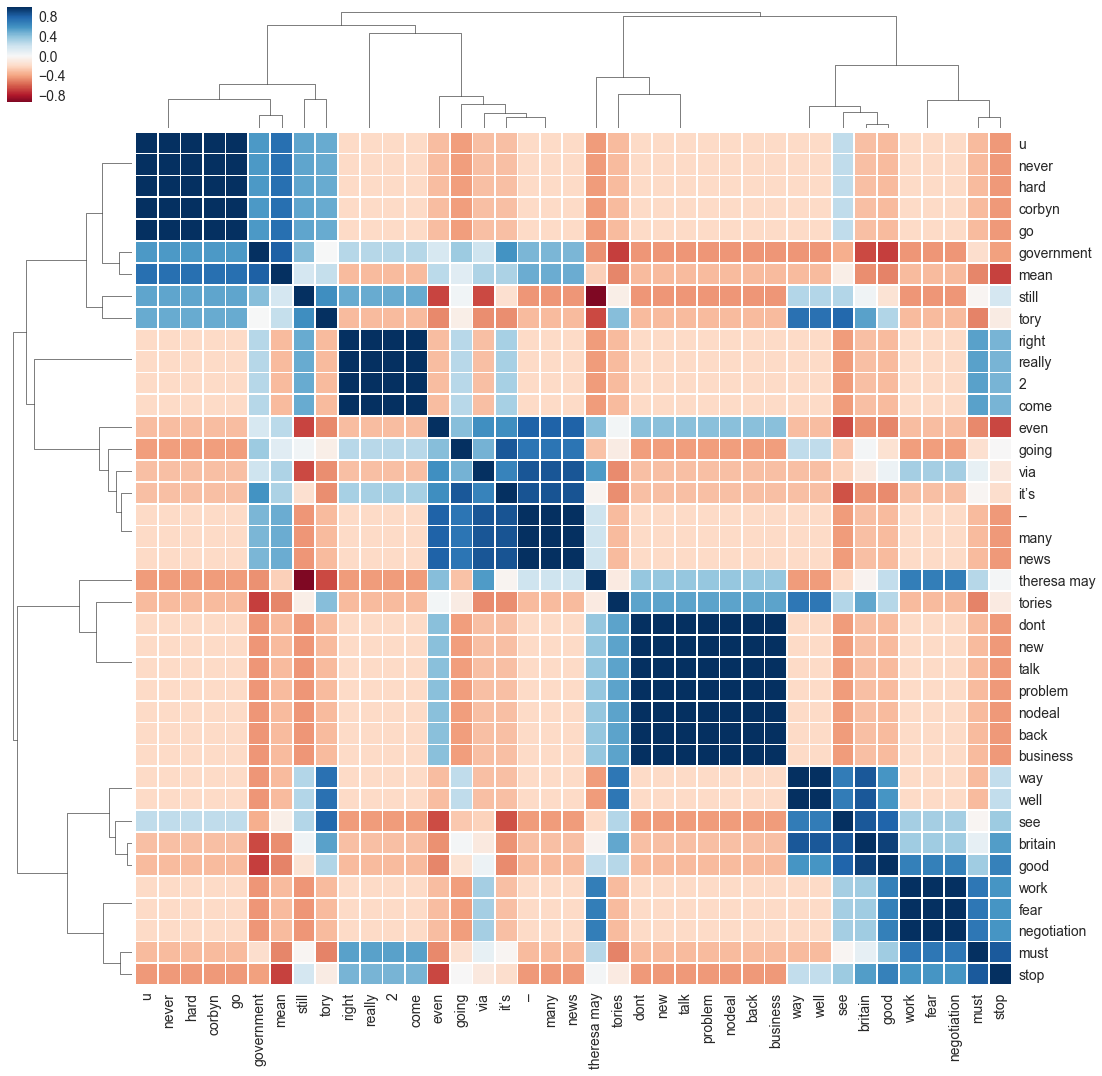

In [47]:
lda = tweetskit.get_lda(corpus, dictionary, num_topic, num_words=10, random_state=1)

In [52]:
lda.show_topics(num_topic, 10)

[(0,
  '0.006*"u" + 0.004*"mean" + 0.004*"corbyn" + 0.004*"hard" + 0.004*"go" + 0.004*"government" + 0.003*"still" + 0.003*"never" + 0.003*"tory" + 0.003*"see"'),
 (1,
  '0.005*"theresa may" + 0.004*"stop" + 0.003*"good" + 0.003*"via" + 0.003*"see" + 0.003*"must" + 0.003*"work" + 0.003*"negotiation" + 0.003*"britain" + 0.002*"fear"'),
 (2,
  '0.006*"nodeal" + 0.004*"back" + 0.003*"theresa may" + 0.003*"tories" + 0.003*"problem" + 0.003*"new" + 0.003*"even" + 0.003*"talk" + 0.003*"dont" + 0.003*"business"'),
 (3,
  '0.006*"via" + 0.005*"it’s" + 0.005*"going" + 0.004*"even" + 0.004*"many" + 0.003*"mean" + 0.003*"government" + 0.003*"–" + 0.003*"theresa may" + 0.003*"news"'),
 (4,
  '0.006*"well" + 0.005*"see" + 0.004*"britain" + 0.004*"tories" + 0.004*"tory" + 0.003*"way" + 0.003*"good" + 0.003*"going" + 0.003*"still" + 0.003*"stop"'),
 (5,
  '0.004*"right" + 0.003*"stop" + 0.003*"still" + 0.003*"going" + 0.003*"it’s" + 0.003*"2" + 0.003*"come" + 0.003*"really" + 0.003*"government" + 0.0

In [49]:
topic = tweetskit.add_topics(sample, lda, texts, corpus)

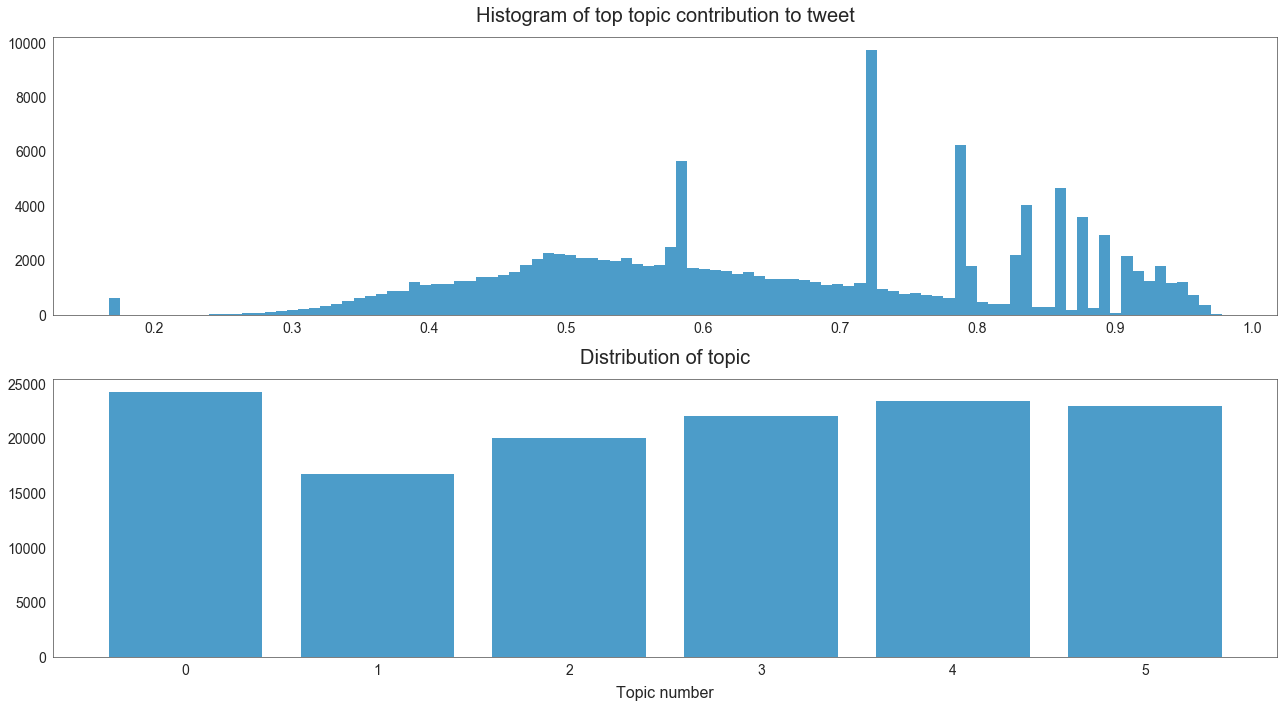

--------------- Most representative tweet for each topic ---------------

Topic 0 (id 1044923109416083456, 2018-09-26T12:14:17.000000000)
"Some uff de grown-ups r-r-reminded me a lot uff mein younger self, uff de time vhen I vas goingkt drough ze teenage kommie phase. Deir r-r-rhetoric sounded a lot like ze dingkts ve used to scribble on ze walls uff de school toilets."
-R-r-reports from ze UK-EU Brexit negotiation


Topic 1 (id 1041264646349574144, 2018-09-16T09:56:52.000000000)
Undt so, Brexit becomes a spiral uff silliness undt hyper-tribalism.
Dis vouldn't hafe happened mitt an EFTA/EEA Brexit. Sure, people vould grumble. It vould still be too brexity for some, undt a betrayal uff Ze Vill Uff Ze People for oders. But dat's not enough for a kulture var


Topic 2 (id 1049615372205400064, 2018-10-09T10:59:40.000000000)
@Brexit You can't take the man who 'forgot' that he'd recently purchased 7 new flats &amp; isn't exactly sure which of the great Asian countries his wife actually comes

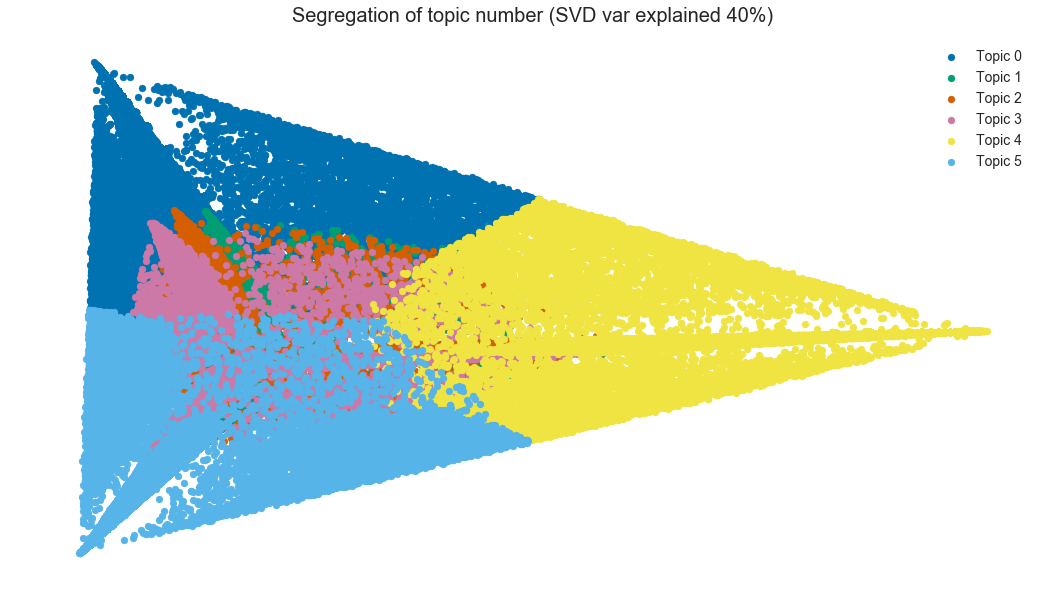

In [50]:
tweetskit.describe_topic(topic)

## Tweet classification using HDBSCAN

While it is not difficult to determine an appropriate threshold to affect a topic to a tweet if most important topic contributes enough to overall tweets, an alternative approach is to cluster tweets using HDBSCAN to eliminate the noise directly

The method below uses (vectorised) bag of words, a truncated SVD which can be applied to a sparse matrix and then classifcation using HDBSCAN 

In [43]:
#hdb_out, hdb = tweetskit.get_cluster(texts, min_size=10000)

In [44]:
#cluster = tweetskit.add_cluster(sample, hdb_out, hdb, texts)

## Tweet sentiment using Vader

The best sentiment analysis method to use on social media text data is probably Vader in sklearn library. The method has been written speciffically for tweets which comes handy here 

Only warning and note would be around false positive such as irony or sarcasm which detection in text is not yet mastered

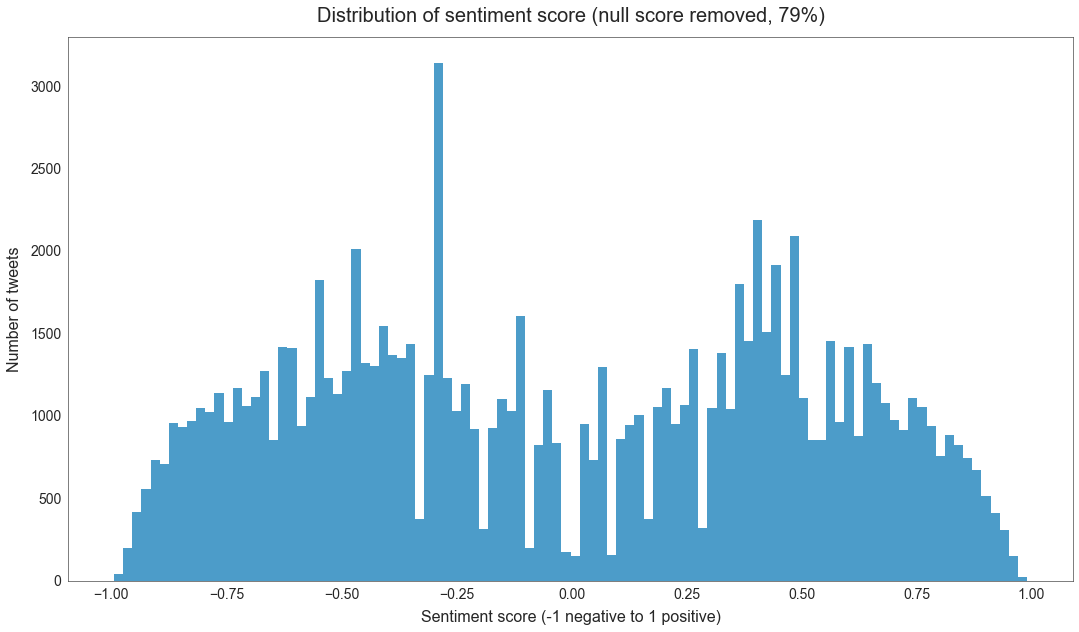

--------------- Most Negative tweets ---------------

Score -0.9944 (id 1047982036173180928, 2018-10-04T22:49:22.000000000)
I hate Theresa May
I hate the way she dances
I hate her lies
I hate her racism
I hate her xenophobia
I hate her forcing Brexit on me against my will
I hate the way she obfuscates 
I hate her weakness
I hate her face
I hate her every time she opens her mouth
I REALLY hate Theresa


Score -0.9941 (id 1042845419498352640, 2018-09-20T18:38:17.000000000)
EVERYTHING in UK is followed by one word - CRISIS 

NHS - CRISIS 
HOUSING - CRISIS
TRANSPORT - CRISIS 
MENTAL HEALTH SERVICES - CRISIS 
CARE SERVICES  - CRISIS 
PRISONS  - CRISIS 
COUNCIL SERVICES  - CRISIS
POLICING  - CRISIS 
.............
BREXIT  - CRISIS 
#peoplesvote
#FBPE


Score -0.9899 (id 1048863382110126080, 2018-10-07T09:11:31.000000000)
Here is @theresa_may’s legacy:

NHS Crisis 
Schools Crisis 
Brexit ruinous
Prison Crisis 
Food bank use UP
Homelessness UP
Poverty UP
Increase in debt 
Ruinous Brexit
Failed 

In [45]:
tweetskit.add_sentiment(sample)